# Code for full simulation

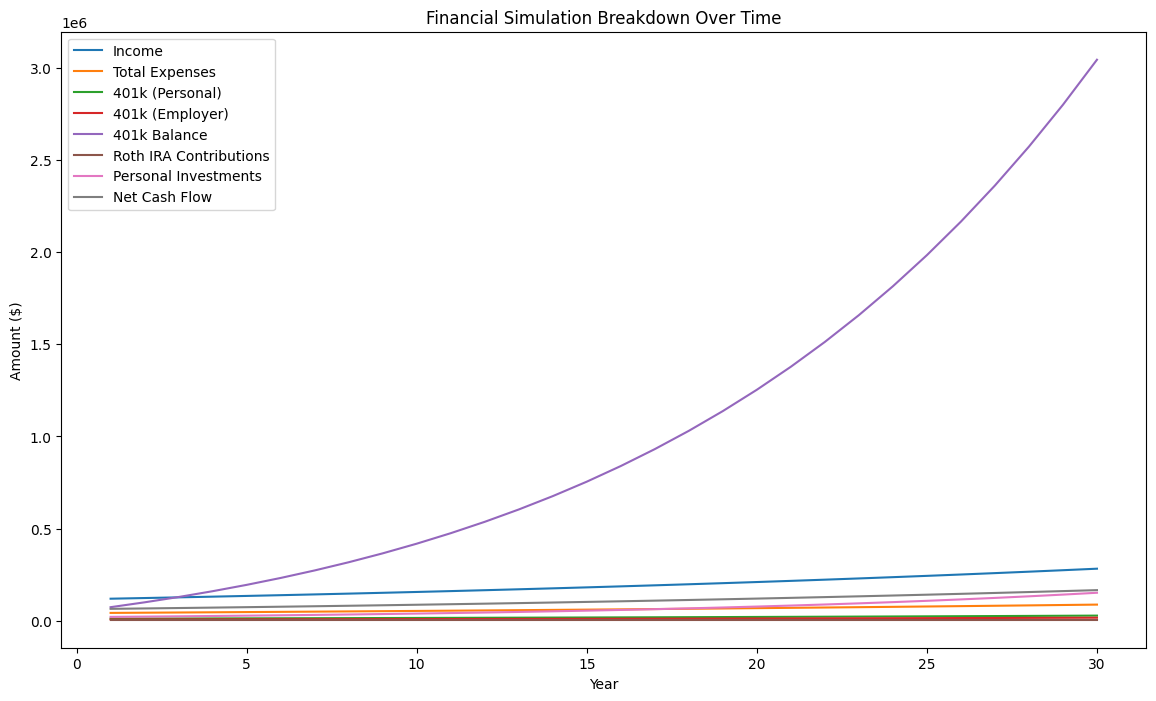

Final DataFrame Output:
    year         income  total_expenses  \
0      1  120000.000000    43000.000000   
1      2  123600.000000    44075.000000   
2      3  127308.000000    45176.875000   
3      4  131127.240000    46306.296875   
4      5  135061.057200    47463.954297   
5      6  139112.888916    48650.553154   
6      7  143286.275583    49866.816983   
7      8  147584.863851    51113.487408   
8      9  152012.409767    52391.324593   
9     10  156572.782060    53701.107708   
10    11  161269.965521    55043.635400   
11    12  166108.064487    56419.726285   
12    13  171091.306422    57830.219443   
13    14  176224.045614    59275.974929   
14    15  181510.766983    60757.874302   
15    16  186956.089992    62276.821159   
16    17  192564.772692    63833.741688   
17    18  198341.715873    65429.585231   
18    19  204291.967349    67065.324861   
19    20  210420.726369    68741.957983   
20    21  216733.348160    70460.506932   
21    22  223235.348605    722

In [5]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt

class Income:
    def __init__(self, base_salary, salary_increase_rate, personal_401k_pct, employer_401k_match_pct):
        self.base_salary = base_salary
        self.salary_increase_rate = salary_increase_rate
        self.personal_401k_pct = personal_401k_pct
        self.employer_401k_match_pct = employer_401k_match_pct

    def annual_income(self, year):
        return self.base_salary * ((1 + self.salary_increase_rate / 100) ** year)

class Investments:
    def __init__(self, roth_ira_contrib, personal_investments, investment_growth_rate, initial_401k_balance=0):
        self.roth_ira_contrib = roth_ira_contrib
        self.personal_investments = personal_investments
        self.investment_growth_rate = investment_growth_rate / 100
        self.k_401_balance = initial_401k_balance

    def grow_investments(self):
        self.k_401_balance *= (1 + self.investment_growth_rate)
        self.personal_investments *= (1 + self.investment_growth_rate)

class Expenses:
    def __init__(self, food, housing, transportation, other, annual_increase_rate):
        self.food = food
        self.housing = housing
        self.transportation = transportation
        self.other = other
        self.annual_increase_rate = annual_increase_rate / 100

    def annual_expenses(self, year):
        growth_factor = (1 + self.annual_increase_rate) ** year
        return {
            'food': self.food * growth_factor,
            'housing': self.housing * growth_factor,
            'transportation': self.transportation * growth_factor,
            'other': self.other * growth_factor
        }

class Simulation:
    def __init__(self, income, investments, expenses, years):
        self.income = income
        self.investments = investments
        self.expenses = expenses
        self.years = years

    def run(self):
        results = []
        for year in range(self.years):
            annual_income = self.income.annual_income(year)
            expenses_breakdown = self.expenses.annual_expenses(year)
            personal_401k = annual_income * (self.income.personal_401k_pct / 100)
            employer_401k = annual_income * (self.income.employer_401k_match_pct / 100)

            self.investments.k_401_balance += personal_401k + employer_401k
            self.investments.grow_investments()

            net_cash_flow = annual_income - sum(expenses_breakdown.values()) - personal_401k

            results.append({
                'year': year + 1,
                'income': annual_income,
                'total_expenses': sum(expenses_breakdown.values()),
                'expenses': expenses_breakdown,
                'personal_401k_contrib': personal_401k,
                'employer_401k_contrib': employer_401k,
                '401k_balance': self.investments.k_401_balance,
                'roth_ira': self.investments.roth_ira_contrib,
                'personal_investments': self.investments.personal_investments,
                'cash_flow': net_cash_flow
            })
        return pd.DataFrame(results)

    def run_and_visualize(self):
        df = self.run()
        #print(df)  # Display DataFrame output

        plt.figure(figsize=(14, 8))
        plt.plot(df['year'], df['income'], label='Income')
        plt.plot(df['year'], df['total_expenses'], label='Total Expenses')
        plt.plot(df['year'], df['personal_401k_contrib'], label='401k (Personal)')
        plt.plot(df['year'], df['employer_401k_contrib'], label='401k (Employer)')
        plt.plot(df['year'], df['401k_balance'], label='401k Balance')
        plt.plot(df['year'], df['roth_ira'], label='Roth IRA Contributions')
        plt.plot(df['year'], df['personal_investments'], label='Personal Investments')
        plt.plot(df['year'], df['cash_flow'], label='Net Cash Flow')
        plt.xlabel('Year')
        plt.ylabel('Amount ($)')
        plt.title('Financial Simulation Breakdown Over Time')
        plt.legend()
        plt.show()

        return df  # Return the DataFrame for external use

example_yaml = {
    'income': {
        'base_salary': 120000,
        'salary_increase_rate': 3.0,
        'personal_401k_pct': 10,
        'employer_401k_match_pct': 6
    },
    'investments': {
        'roth_ira_contrib': 6000,
        'personal_investments': 20000,
        'investment_growth_rate': 7.0,
        'initial_401k_balance': 50000
    },
    'expenses': {
        'food': 8000,
        'housing': 24000,
        'transportation': 6000,
        'other': 5000,
        'annual_increase_rate': 2.5
    },
    'years': 30
}

def run_test():
    income = Income(**example_yaml['income'])
    investments = Investments(**example_yaml['investments'])
    expenses = Expenses(**example_yaml['expenses'])
    sim = Simulation(income, investments, expenses, example_yaml['years'])
    df = sim.run_and_visualize()
    return df

if __name__ == "__main__":
    df_output = run_test()
    print("Final DataFrame Output:")
    print(df_output)


In [6]:
df_output

,year,income,total_expenses,expenses,personal_401k_contrib,employer_401k_contrib,401k_balance,roth_ira,personal_investments,cash_flow
0,1,120000.000000,43000.000000,"{'food': 8000.0, 'housing': 24000.0, 'transpor...",12000.000000,7200.000000,7.404400e+04,6000,21400.000000,65000.000000
1,2,123600.000000,44075.000000,"{'food': 8200.0, 'housing': 24599.999999999996...",12360.000000,7416.000000,1.003874e+05,6000,22898.000000,67165.000000
2,3,127308.000000,45176.875000,"{'food': 8405.0, 'housing': 25214.999999999996...",12730.800000,7638.480000,1.292096e+05,6000,24500.860000,69400.325000
3,4,131127.240000,46306.296875,"{'food': 8615.124999999996, 'housing': 25845.3...",13112.724000,7867.634400,1.607033e+05,6000,26215.920200,71708.219125
4,5,135061.057200,47463.954297,"{'food': 8830.503124999996, 'housing': 26491.5...",13506.105720,8103.663432,1.950750e+05,6000,28051.034614,74090.997183
5,6,139112.888916,48650.553154,"{'food': 9051.265703124995, 'housing': 27153.7...",13911.288892,8346.773335,2.325464e+05,6000,30014.607037,76551.046870
6,7,143286.275583,49866.816983,"{'food': 9277.54734570312, 'housing': 27832.64...",14328.627558,8597.176535,2.733552e+05,6000,32115.629530,79090.831042
7,8,147584.863851,51113.487408,"{'food': 9509.486029345699, 'housing': 28528.4...",14758.486385,8855.091831,3.177566e+05,6000,34363.723597,81712.890058
8,9,152012.409767,52391.324593,"{'food': 9747.223180079338, 'housing': 29241.6...",15201.240977,9120.744586,3.660241e+05,6000,36769.184248,84419.844197
9,10,156572.782060,53701.107708,"{'food': 9990.903759581322, 'housing': 29972.7...",15657.278206,9394.366924,4.184511e+05,6000,39343.027146,87214.396146


# Doing the Life Event

In [94]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt

class Income:
    def __init__(self, base_salary, salary_increase_rate, personal_401k_pct, employer_401k_match_pct):
        self.base_salary = base_salary
        self.salary_increase_rate = salary_increase_rate
        self.personal_401k_pct = personal_401k_pct
        self.employer_401k_match_pct = employer_401k_match_pct

    def annual_income(self, year):
        return self.base_salary * ((1 + self.salary_increase_rate / 100) ** year)

class Investments:
    def __init__(self, roth_ira_contrib, personal_investments, investment_growth_rate, initial_401k_balance=0):
        self.roth_ira_contrib = roth_ira_contrib
        self.personal_investments = personal_investments
        self.investment_growth_rate = investment_growth_rate / 100
        self.k_401_balance = initial_401k_balance

    def grow_investments(self):
        self.k_401_balance *= (1 + self.investment_growth_rate)
        self.personal_investments *= (1 + self.investment_growth_rate)

class Expenses:
    def __init__(self, food, housing, transportation, other, annual_increase_rate):
        self.food = food
        self.housing = housing
        self.transportation = transportation
        self.other = other
        self.annual_increase_rate = annual_increase_rate / 100

    def annual_expenses(self, year):
        growth_factor = (1 + self.annual_increase_rate) ** year
        return {
            'food': self.food * growth_factor,
            'housing': self.housing * growth_factor,
            'transportation': self.transportation * growth_factor,
            'other': self.other * growth_factor
        }

class LifeEvent:
    def __init__(self, year, description, income_change=0):
        self.year = year
        self.description = description
        self.income_change = income_change

    def apply(self):
        self.income.base_salary = self.income.base_salary + self.income_change



class Simulation:
    def __init__(self, income, investments, expenses, years):
        self.income = income
        self.investments = investments
        self.expenses = expenses
        self.years = years

    def run(self):
        results = []
        for year in range(self.years):
            # Set Everything
            annual_income = self.income.annual_income(year)
            expenses_breakdown = self.expenses.annual_expenses(year)
            personal_401k = annual_income * (self.income.personal_401k_pct / 100)
            employer_401k = annual_income * (self.income.employer_401k_match_pct / 100)

            self.investments.k_401_balance += personal_401k + employer_401k
            self.investments.grow_investments()

            net_cash_flow = annual_income - sum(expenses_breakdown.values()) - personal_401k

            results.append({
                'year': year + 1,
                'income': annual_income,
                'total_expenses': sum(expenses_breakdown.values()),
                'expenses': expenses_breakdown,
                'personal_401k_contrib': personal_401k,
                'employer_401k_contrib': employer_401k,
                '401k_balance': self.investments.k_401_balance,
                'roth_ira': self.investments.roth_ira_contrib,
                'personal_investments': self.investments.personal_investments,
                'cash_flow': net_cash_flow
            })
            if year == 2: 
                print('yay')
                self.income.base_salary = 0

        return pd.DataFrame(results)
        #return results

    def run_simulation(self):
        simulation_output = self.run()
        return simulation_output


In [95]:
def load_inputs(file_path = "inputs.yaml"):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
        return config

In [96]:
example_yaml = load_inputs()
example_yaml

{'income': {'base_salary': 120000,
  'salary_increase_rate': 3.0,
  'personal_401k_pct': 10,
  'employer_401k_match_pct': 6},
 'investments': {'roth_ira_contrib': 6000,
  'personal_investments': 20000,
  'investment_growth_rate': 7.0,
  'initial_401k_balance': 50000},
 'expenses': {'food': 8000,
  'housing': 24000,
  'transportation': 6000,
  'other': 5000,
  'annual_increase_rate': 2.5},
 'years': 30,
 'life_events': [{'year': 7,
   'description': 'Salary drop due to job change',
   'income_change': -100000},
  {'year': 20,
   'description': 'Salary grows due to job change',
   'income_change': 2000000}]}

In [97]:

def run_test():
    income = Income(**example_yaml['income'])
    investments = Investments(**example_yaml['investments'])
    expenses = Expenses(**example_yaml['expenses'])
    sim = Simulation(income, investments, expenses, example_yaml['years'])
    simulation_output = sim.run_simulation()
    return simulation_output

if __name__ == "__main__":
    simulation_output = run_test()
    #print("Final DataFrame Output:")
    #print(simulation_output)

yay


In [98]:
simulation_output

,year,income,total_expenses,expenses,personal_401k_contrib,employer_401k_contrib,401k_balance,roth_ira,personal_investments,cash_flow
0,1,120000.0,43000.000000,"{'food': 8000.0, 'housing': 24000.0, 'transpor...",12000.0,7200.00,74044.000000,6000,21400.000000,65000.000000
1,2,123600.0,44075.000000,"{'food': 8200.0, 'housing': 24599.999999999996...",12360.0,7416.00,100387.400000,6000,22898.000000,67165.000000
2,3,127308.0,45176.875000,"{'food': 8405.0, 'housing': 25214.999999999996...",12730.8,7638.48,129209.647600,6000,24500.860000,69400.325000
3,4,0.0,46306.296875,"{'food': 8615.124999999996, 'housing': 25845.3...",0.0,0.00,138254.322932,6000,26215.920200,-46306.296875
4,5,0.0,47463.954297,"{'food': 8830.503124999996, 'housing': 26491.5...",0.0,0.00,147932.125537,6000,28051.034614,-47463.954297
5,6,0.0,48650.553154,"{'food': 9051.265703124995, 'housing': 27153.7...",0.0,0.00,158287.374325,6000,30014.607037,-48650.553154
6,7,0.0,49866.816983,"{'food': 9277.54734570312, 'housing': 27832.64...",0.0,0.00,169367.490528,6000,32115.629530,-49866.816983
7,8,0.0,51113.487408,"{'food': 9509.486029345699, 'housing': 28528.4...",0.0,0.00,181223.214865,6000,34363.723597,-51113.487408
8,9,0.0,52391.324593,"{'food': 9747.223180079338, 'housing': 29241.6...",0.0,0.00,193908.839905,6000,36769.184248,-52391.324593
9,10,0.0,53701.107708,"{'food': 9990.903759581322, 'housing': 29972.7...",0.0,0.00,207482.458698,6000,39343.027146,-53701.107708
